<img style="float: left; width: 260px;" src="images/shutterstock_318255209.jpg">
***
## <font color="grey"> $\quad$ BRAF vs NRAS and age</font>
***
$\newcommand{\vct}[1]{\mathbf{#1}}$
$\newcommand{\mtx}[1]{\mathbf{#1}}$
$\newcommand{\e}{\varepsilon}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\minimize}{\text{minimize}\quad}$
$\newcommand{\maximize}{\text{maximize}\quad}$
$\newcommand{\subjto}{\quad\text{subject to}\quad}$
$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\trans}{T}$
$\newcommand{\ip}[2]{\langle {#1}, {#2} \rangle}$
$\newcommand{\zerovct}{\vct{0}}$
$\newcommand{\diff}[1]{\mathrm{d}{#1}}$
$\newcommand{\conv}{\operatorname{conv}}$
$\newcommand{\inter}{{\operatorname{int}}}$

---
## <font color="grey">  1. General remarks</font>
---

First of all, I'm using Python simply because I'm most used to it in the context of other work. I could switch to R if that makes life easier for all (while still using a Jupyter notebook). You may happily skip the code parts and stick to the text and graphs, that should contain enough explanation.

### <font color="grey">  1.1 Questions regarding terminology and data interpretation </font>

**The situation: ** we have a lot of melanoma samples categorised according to BRAF and NRAS. We want to find out whether there is a difference in extrinsic risk between the two types. For that we need to 

* quantify what we mean by extrinsic risk (exposure to signature 7? total number of SNVs associated to signature 7? number of C>T transpositions? ratio or percentages associated to the previous quantities?), and
* decide what we want to infer about the samples (cell division rate?) 

**What the data suggests (summary): ** From the data it appears as if the extrinsic/intrinsic ratio (measured in different ways) does not change in NRAS with age, but does change slightly in BRAF (not sure if statistically significant though). What does change with age in NRAS is the total intrinsic mutation load (again, measured in different ways such as non C>T changes or exposure to signature 1), but also the mutation count in general. If we had any idea of mutation rates per cell division, we could infer things like cell division rate.

Could it be that in the BRAF samples, the melanoma appears after a fixed number of mutations (regardless of age), while in the NRAS samples this can be variable? 

### <font color="grey">  1.2 Data used </font>

I've looked at different data sets covering the same samples, the main ones being:

* **tcga_sigs_229.xls** Contains the relevant age and NRAS/BRAF information, as well as normalised signature exposures.
* **ncomms12064-s3.csv** From the  [MC1R paper by Robles-Espinoza et al](http://www.nature.com/articles/ncomms12064). Contains pretty much the same samples (from the TCGA database) but with different additional information and with absolute mutation catalogs.

**Question: ** What unit are our SNVs counted in? Per GBase pair? How was the exposure to the different signatures computed?

---
## <font color="grey">  2. What is, and what isn't, correlated with age?</font>
---

In this part I'm just looking for any relation with age of SNV counts and other parameters. Given the nature of the data and the many outliers, I'm using robust regression throughout (with the [Huber estimator](https://en.wikipedia.org/wiki/Huber_loss)). One can leave aside the theoretical justification for the time being, it seems to work just fine.

### <font color="grey">  2.1 Simple SNV count with main dataset</font>

Here I correlate the total non-UV count with age for BRAF and NRAS samples. There seems to be a correlation with age when looking at the NRAS cohort, but not with the other.

**Question: ** By "non-UV" do we mean SNVs that are left over after accounting for Signature 7?

The below just loads the data from the file into convenient arrays and data structures, as usual the code can be ignored.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats

# Get relevant data from Simon and Amayas data
tcga_meta = pd.read_csv('data/tcga_sigs_229_meta.csv')
print tcga_meta.head(3)

names = tcga_meta['Sample'].values
n = len(names)
ages = tcga_meta['Age'].values.astype(float)
snvs = tcga_meta['SNVs'].values.astype(float)
uv_snvs = tcga_meta['UV_SNVs'].values.astype(float)
nuv_snvs = snvs - uv_snvs
nuv_snvs_pc = 100.-tcga_meta['Perc_UV_SNVs'].values.astype(float)

snv_matrix = np.concatenate((snvs.reshape((n,1)), nuv_snvs.reshape((n,1)), 
                             nuv_snvs_pc.reshape((n,1)), nuv_snvs.reshape((n,1))/uv_snvs.reshape((n,1))), axis=1)

cohort = tcga_meta['Cohort'].values.tolist()
braf_inds = [i for i,x in enumerate(cohort) if x == 'BRAF']
nras_inds = [i for i,x in enumerate(cohort) if x == 'NRAS']
cohort_dict = zip(names, cohort)

         Sample  Age     AA  SNVs  UV_SNVs  Perc_UV_SNVs Cohort
0  TCGA-BF-A1PU   46  V600E    95       73       76.8421   BRAF
1  TCGA-BF-A1PV   74   Q61L   333      263       78.9790   NRAS
2  TCGA-BF-A1PZ   71   Q61R   270      200       74.0741   NRAS


We first look whether we can detect any age correlation of the total SNV counts (both non-UV and all). 

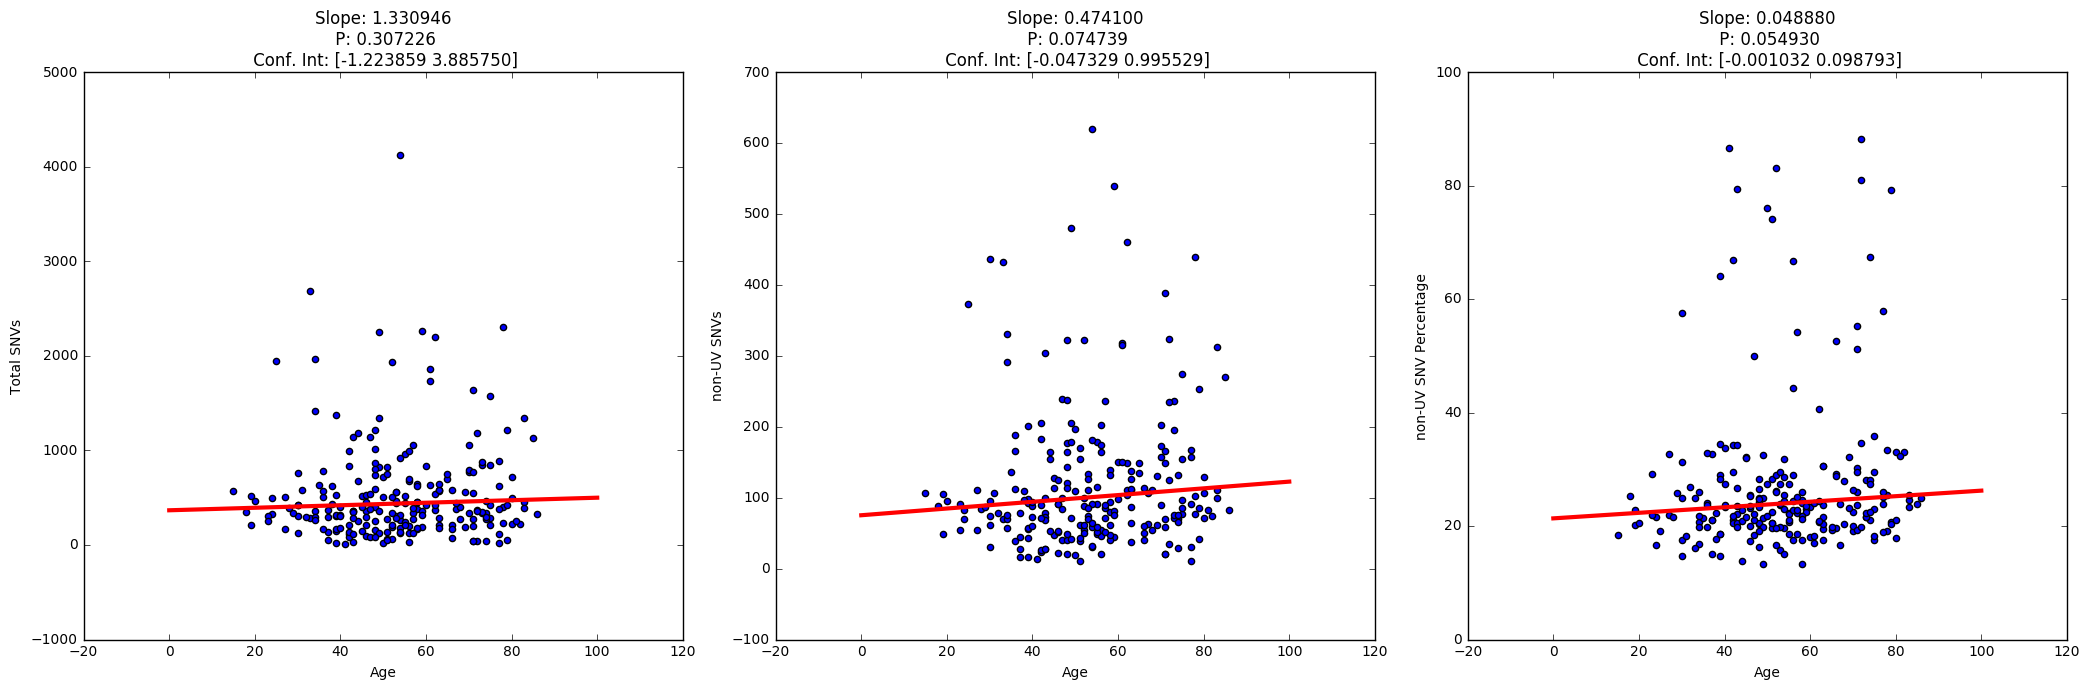

In [2]:
# Compute robust regression
import matplotlib.pyplot as plt
% matplotlib inline

xx = np.linspace(0,100,100)
X = sm.add_constant(ages.reshape((len(ages),1)))
ylabels = ["Total SNVs", "non-UV SNVs", "non-UV SNV Percentage", "Ratio non-UV/UV SNVs"]

fig, ax = plt.subplots(1,3)
fig.set_size_inches(21,7)
for i in range(3):
    ax[i].scatter(ages, snv_matrix[:,i])
    res = sm.RLM(snv_matrix[:,i], X, M=sm.robust.norms.HuberT(1.345)).fit()
    ax[i].plot(xx, res.params[0]+res.params[1]*xx, linewidth=3, color='red')
    mytitle = "Slope: {:f}".format(res.params[1])+"\n P: {:f}".format(res.pvalues[1])+"\n Conf. Int: [{:f} {:f}]".format(*res.conf_int()[1,:])
    ax[i].set_title(mytitle)
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_xlabel("Age")
plt.tight_layout()
plt.show()

In [3]:
# Look at Spearman rho (rank) correlation
result = stats.spearmanr(ages, nuv_snvs)
print "The Spearman rho coefficient is", result[0], "with P-value", result[1]

The Spearman rho coefficient is 0.117521643366 with P-value 0.0759229028407


**Question: ** Is there supposed to be a stronger correlation here? The robust estimators do a good job at not getting distracted by the points hovering above the main cloud, but maybe we want to account for them too?

### <font color="grey">  2.2 SNV count for NRAS and BRAF in relation to age with main dataset</font>

We next differentiate between BRAF and NRAS samples. The non-UV SNV count shows quite a difference, and we also look at the proportions.

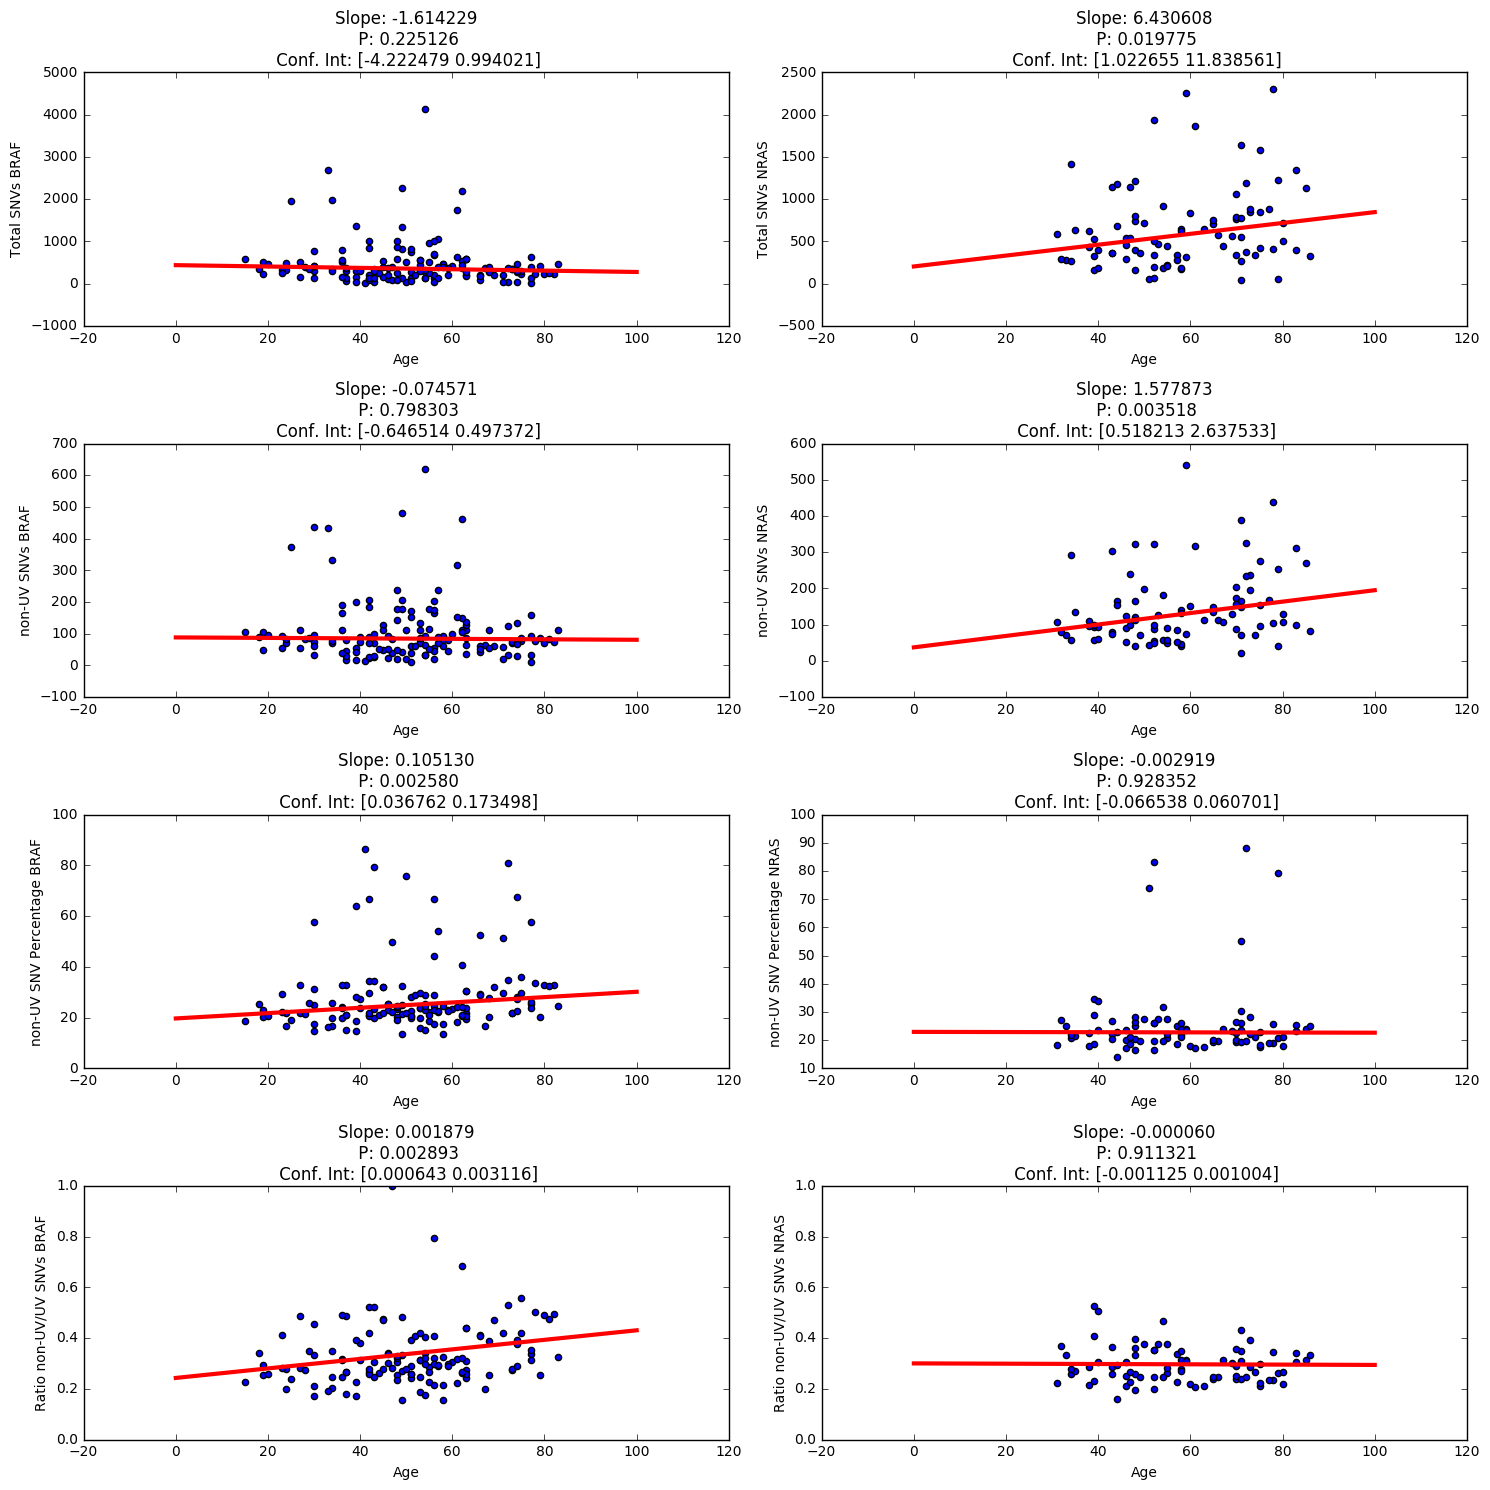

In [4]:
X = sm.add_constant(ages.reshape((len(ages),1)))
fig, ax = plt.subplots(4,2)
fig.set_size_inches(15,15)

for i in range(4):
    ax[i,0].scatter(ages[braf_inds], snv_matrix[braf_inds,i])
    res = sm.RLM(snv_matrix[braf_inds,i], X[braf_inds,:], M=sm.robust.norms.HuberT(1.345)).fit()
    ax[i,0].plot(xx, res.params[0]+res.params[1]*xx, linewidth=3, color='red')
    mytitle = "Slope: {:f}".format(res.params[1])+"\n P: {:f}".format(res.pvalues[1])+"\n Conf. Int: [{:f} {:f}]".format(*res.conf_int()[1,:])
    ax[i,0].set_title(mytitle)
    ax[i,0].set_ylabel(ylabels[i]+" BRAF")
    ax[i,0].set_xlabel("Age")
    if i==3:
        ax[i,0].set_ylim([0,1])
    
    ax[i,1].scatter(ages[nras_inds], snv_matrix[nras_inds,i])
    res = sm.RLM(snv_matrix[nras_inds,i], X[nras_inds,:], M=sm.robust.norms.HuberT(1.345)).fit()
    ax[i,1].plot(xx, res.params[0]+res.params[1]*xx, linewidth=3, color='red')
    mytitle = "Slope: {:f}".format(res.params[1])+"\n P: {:f}".format(res.pvalues[1])+"\n Conf. Int: [{:f} {:f}]".format(*res.conf_int()[1,:])
    ax[i,1].set_title(mytitle)
    ax[i,1].set_ylabel(ylabels[i]+" NRAS")
    ax[i,1].set_xlabel("Age")
    if i==3:
        ax[i,1].set_ylim([0,1])
plt.tight_layout()
plt.show()

Based on the increase in non-UV SNVs of 1.6 per year and the estimate of SNVs per cell division (the number from the [Wu paper](http://www.nature.com/nature/journal/v529/n7584/full/nature16166.html) does not seem adequate, as it is about *driver mutations*) we could (crudely) infer cell divisions per year. Also based on the last pair above, the ratio of non-UV/UV does seem to change (slightly) with age in the BRAF samples, and stay constant in the NRAS group.

**Question: ** What is a driver mutation in our context? Do the above conclusions make sense?

**Summary so far: ** For the BRAF samples, the total SNV count and the non-UV SNV count do not seem to increase with age, while the proportion of non-UV SNVs does seem to increase slightly. For NRAS the total SNV count and non-UV SNV count does seem to increase with age, but so does the UV count, and the proportion stays the same. So the difference seems to be an overall increase of SNVs with age in NRAS. 

**Question: ** Why does the number of UV SNVs increase with age in NRAS? Is there an overlap? 

If we assume a Poisson process generating $\lambda$ SNVs a year (or other quantities, such as exposure to a signature), then we can estimate $\lambda$ by taking the average of the SNVs per year.

For UV SNVs / Age the BRAF mean is 8.291735 and the NRAS mean is 8.982240
For non-UV SNVs / Age the BRAF mean is 2.367701 and the NRAS mean is 2.531640


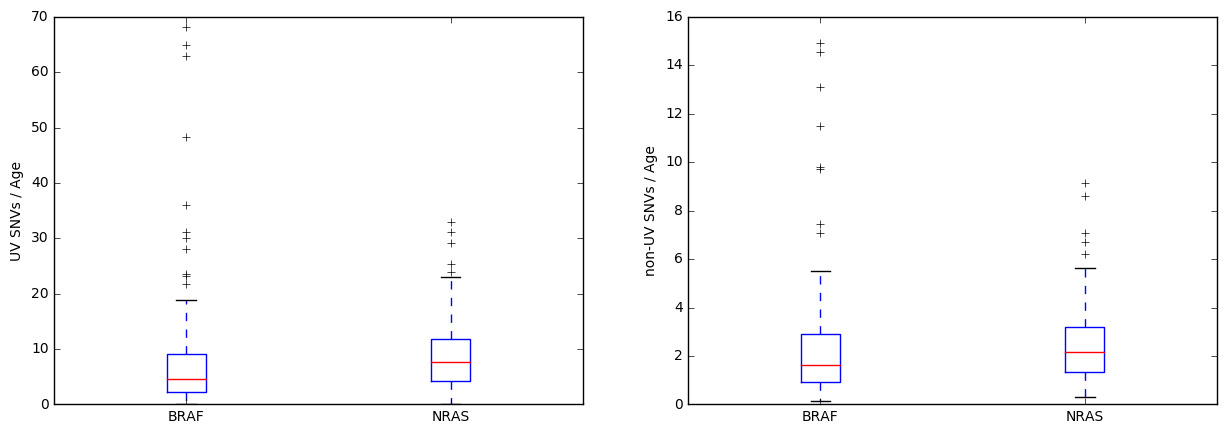

In [5]:
snv_age_matrix = np.concatenate((uv_snvs.reshape((n,1)), nuv_snvs.reshape((n,1))), axis=1)/np.tile(ages.reshape((n,1)),(1,2))
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,5)
ylabels = ['UV SNVs / Age', 'non-UV SNVs / Age']
for i in range(2):
    res_braf = np.mean(snv_age_matrix[braf_inds,i])
    res_nras = np.mean(snv_age_matrix[nras_inds,i])
    ax[i].boxplot([snv_age_matrix[braf_inds,i], snv_age_matrix[nras_inds,i]])
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_xticklabels(['BRAF', 'NRAS'])
    print "For "+ylabels[i]+" the BRAF mean is {:f}".format(res_braf)+" and the NRAS mean is {:f}".format(res_nras)

The presence of outliers seems to make the difference less marked than it should be. A sensible approach is to use robust regression. Below I compute the average of the SNVs/age and the robust average (using the [Huber estimator](https://en.wikipedia.org/wiki/Huber_loss)). I haven't included P values or confidence intervals here, but they are quite good.

In [6]:
types = ['UV SNVs', 'non-UV SNVs']
for i in range(2):
    res_nras = sm.RLM(snv_age_matrix[nras_inds,i], np.ones_like(snv_age_matrix[nras_inds,i]), M=sm.robust.norms.HuberT(1.345)).fit()
    print "The robust average of "+types[i]+" among NRAS is {:f}".format(res_nras.params[0])+" with confidence interval [{:f}, {:f}]".format(*res_nras.conf_int()[0,:])
    res_braf =  sm.RLM(snv_age_matrix[braf_inds,i], np.ones_like(snv_age_matrix[braf_inds,i]), M=sm.robust.norms.HuberT(1.345)).fit()
    print "The robust average of "+types[i]+" among BRAF is {:f}".format(res_braf.params[0])+" with confidence interval [{:f}, {:f}]".format(*res_braf.conf_int()[0,:])

The robust average of UV SNVs among NRAS is 8.008704 with confidence interval [6.848370, 9.169038]
The robust average of UV SNVs among BRAF is 5.986230 with confidence interval [5.147930, 6.824530]
The robust average of non-UV SNVs among NRAS is 2.275167 with confidence interval [2.010525, 2.539808]
The robust average of non-UV SNVs among BRAF is 1.875892 with confidence interval [1.650712, 2.101072]


**Interpretation: ** The SNVs/year values for NRAS are 21-25 % higher than for BRAF. Not sure how to interpret such a thing, though, as the age correlation is not visible among the BRAF samples.

**Worth considering: ** Assuming that the non-UV mutations accumulate at a fixed rate per year, we can use Poisson regression (or better here, negative binomial regression) to estimate the average number of hits per year controlling for various other factors, as in the [MC1R paper by Robles-Espinoza et al](http://www.nature.com/articles/ncomms12064). This would allow to get similar conclusions as in their paper, with the categories corresponding to the number of R alleles of MC1R replaced by BRAF / NRAS.  I'm not familiar with the imputation methods they use to deal with missing or categorical data, but other than that, what they do is pretty straightforward.

### <font color="grey">  2.3 SNV count for NRAS and BRAF in relation to age with alternative dataset</font>

Now repeat the above using the MC1R data, where we use the amount of C>T transpositions as measure for UV contribution, and all others as non-UV. First we have to figure out the subset of samples that is available in both sources.

In [7]:
# Get data from MC1R paper and compare SNV counts among those samples available in both data sets
mc1r3 = pd.read_csv('data/ncomms12064-s3.csv', header=1)
mc1r3 = mc1r3.dropna(subset=['totalSNV', 'age_at_diagnosis', 'totalNonUV', 'totalSNV'])
snvs = mc1r3['totalSNV'].values.astype('float')
sub_names = [x for x in mc1r3['BARCODE'] if x in tcga_meta['Sample'].values]
mc1r3 = mc1r3[mc1r3['BARCODE'].isin(sub_names)]
indices = [tcga_meta['Sample'].values.tolist().index(x) for x in mc1r3['BARCODE'].values]

# Get the new data
snvs_1 = mc1r3['totalSNV'].values.astype(float)
nuv_snvs_1 = mc1r3['totalNonUV'].values.astype('float')
ages_1 = mc1r3['age_at_diagnosis'].values.astype('float')
cohort_1 = tcga_meta['Cohort'].values[indices]
braf_inds_1 = [i for i,x in enumerate(cohort_1) if x == 'BRAF']
nras_inds_1 = [i for i,x in enumerate(cohort_1) if x == 'NRAS']
snv_matrix_1 = np.concatenate((snvs_1.reshape((len(snvs_1),1)), nuv_snvs_1.reshape((len(snvs_1),1))), axis=1)

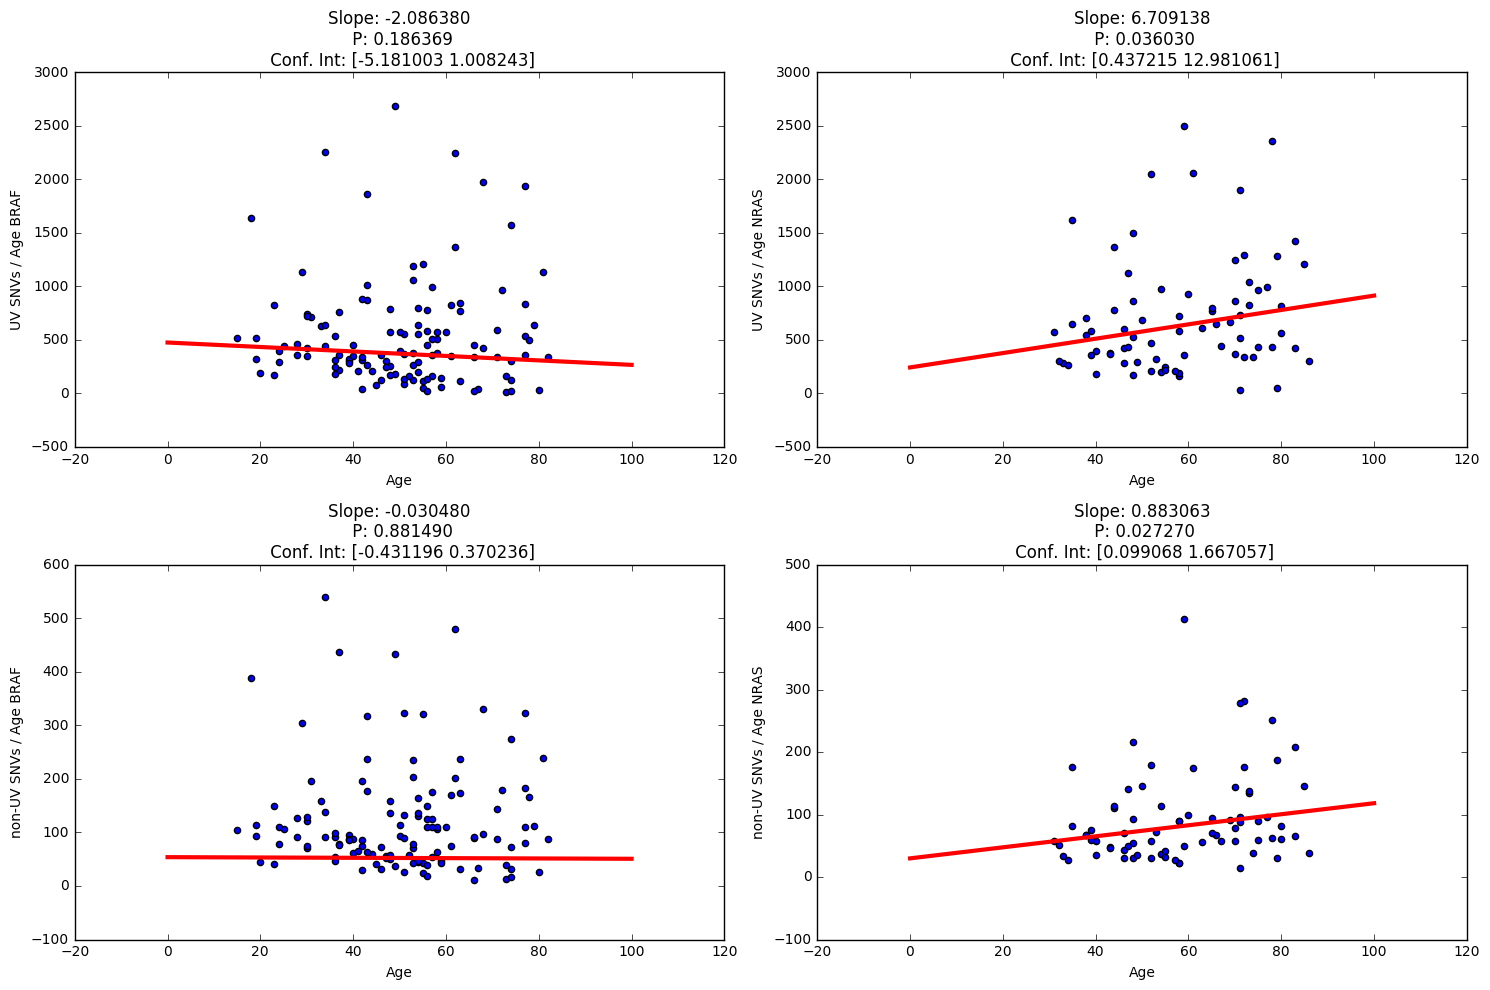

In [8]:
# Plot the new data
X = sm.add_constant(ages_1.reshape((len(ages_1),1)))
fig, ax = plt.subplots(2,2)
fig.set_size_inches(15,10)

for i in range(2):
    ax[i,0].scatter(ages_1[braf_inds_1], snv_matrix[braf_inds_1,i])
    res = sm.RLM(snv_matrix_1[braf_inds_1,i], X[braf_inds_1,:], M=sm.robust.norms.HuberT(1.345)).fit()
    ax[i,0].plot(xx, res.params[0]+res.params[1]*xx, linewidth=3, color='red')
    mytitle = "Slope: {:f}".format(res.params[1])+"\n P: {:f}".format(res.pvalues[1])+"\n Conf. Int: [{:f} {:f}]".format(*res.conf_int()[1,:])
    ax[i,0].set_title(mytitle)
    ax[i,0].set_ylabel(ylabels[i]+" BRAF")
    ax[i,0].set_xlabel("Age")
    
    ax[i,1].scatter(ages_1[nras_inds_1], snv_matrix_1[nras_inds_1,i])
    res = sm.RLM(snv_matrix_1[nras_inds_1,i], X[nras_inds_1,:], M=sm.robust.norms.HuberT(1.345)).fit()
    ax[i,1].plot(xx, res.params[0]+res.params[1]*xx, linewidth=3, color='red')
    mytitle = "Slope: {:f}".format(res.params[1])+"\n P: {:f}".format(res.pvalues[1])+"\n Conf. Int: [{:f} {:f}]".format(*res.conf_int()[1,:])
    ax[i,1].set_title(mytitle)
    ax[i,1].set_ylabel(ylabels[i]+" NRAS")
    ax[i,1].set_xlabel("Age")
plt.tight_layout()
plt.show()

The overall pattern is similar (not surprising, as it's the same data, though with some differences). Only thing is that here we count any non C>T change as not related to UV.

**Question: ** Why is there a difference in SNV counts with the [Robles-Espinoza et al](http://www.nature.com/articles/ncomms12064) paper? It can't be different scaling or unit as otherwise they should be somehow proportional. The describe how they got their counts in their paper, didn't get that part.

**Question: ** How can one explain that in NRAS also the amount of C>T changes is correlated with age and in BRAF not?

### <font color="grey">  2.4 Signature exposure</font>

Have a look at what signatures 1, 5 and 7 look like (these are the only ones considered with respect to Melanoma in the [Clock](http://www.nature.com/ng/journal/v47/n12/abs/ng.3441.html) paper).

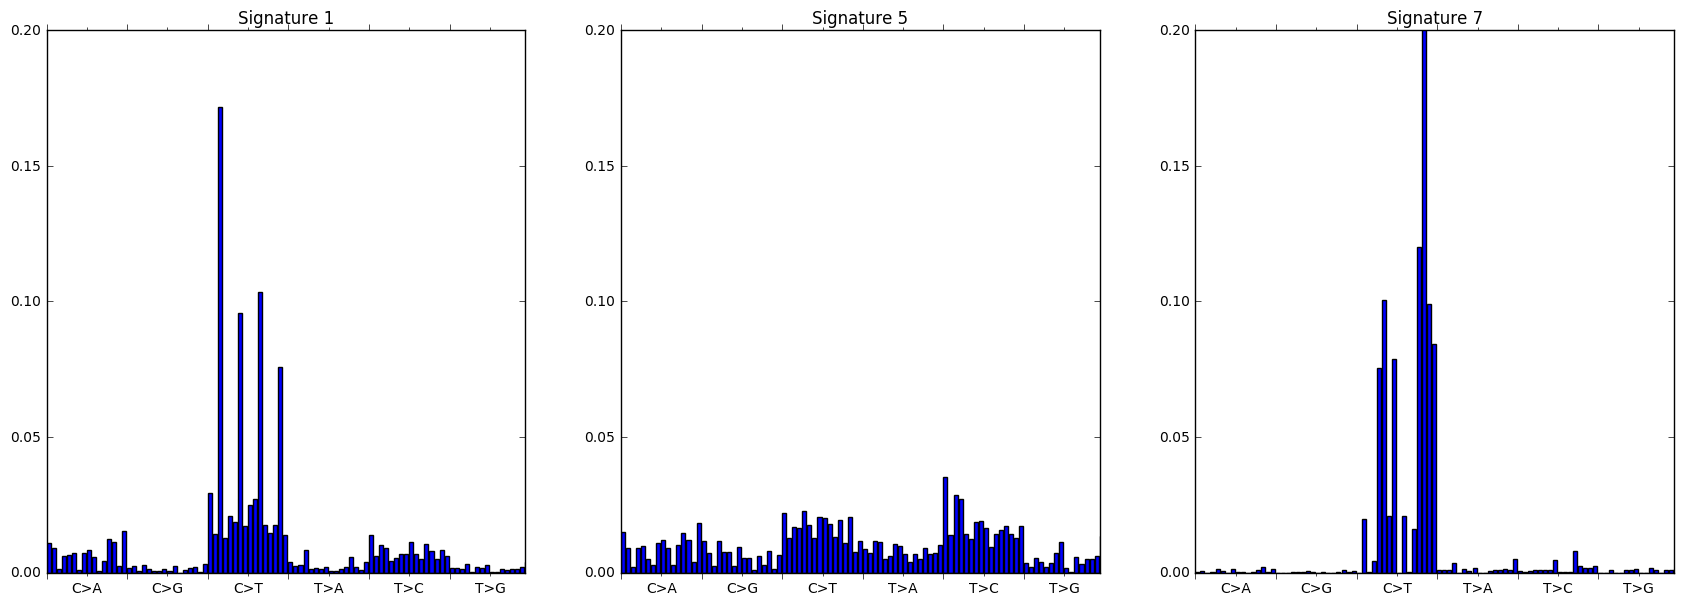

In [9]:
# This is a bit messy, but it's just to get the different transpositions in order
codes = [x for x in mc1r3.columns if '.in.' in x]
signature_data = pd.read_csv('data/signatures_probabilities.txt', sep='\t')
signatures = signature_data.values[:,3:-7].astype('float64')
newcodes = ["{}.in.{}".format(x_,y_).replace(">",".") for (x_,y_) in zip(signature_data.values[:,0], signature_data.values[:,1])]
indices = [newcodes.index(x) for x in codes]
sorted_newcodes = [newcodes[i] for i in indices]
P = signatures[indices,:]
P = P[:,[0,4,6]]

from matplotlib import rcParams
rcParams['xtick.direction'] = 'out'
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(21,7)
code_labels = ['C>A', 'C>G', 'C>T', 'T>A', 'T>C', 'T>G']
titles = ['Signature 1', 'Signature 5', 'Signature 7']
ticks = np.arange(8, 95, 16)
minor_ticks = np.arange(0, 95, 16)
for i in range(3):
    ax[i].set_ylim([0,0.2])
    ax[i].bar(list(range(P.shape[0])), P[:,i])
    ax[i].set_xlim([0,95])
    ax[i].set_xticks(ticks, minor=True)
    ax[i].set_xticks(minor_ticks)
    ax[i].set_xticklabels([])
    ax[i].set_xticklabels(code_labels, minor=True)
    ax[i].set_title(titles[i])
plt.show()

It appears that simply counting the prevalence of C>T should account for Signatures 1 and 7, but not sure if it differentiates them well.

**Question: ** How were the exposures to each each signature computed in Simon's dataset?

Here we do three things:
* Use the normalised exposures from the data by Simon and Amaya
* Use the mutation catalogs from the MC1R paper and project them to the cone generated by signatures 1, 5 and 7 (so that we get the closest non-negative linear combination of these signatures to our sample).

In [10]:
tcga_sigs = pd.read_csv('data/tcga_sigs_229_sig.csv')
E = tcga_sigs[[x for x in tcga_sigs.columns if 'Signature' in x]].values.astype('float')
E_red = E[:,[0,6]] # Only signatures 1 and 7

First compare the average contribution of signature 1 and signature 7 in both cohorts when divided by age

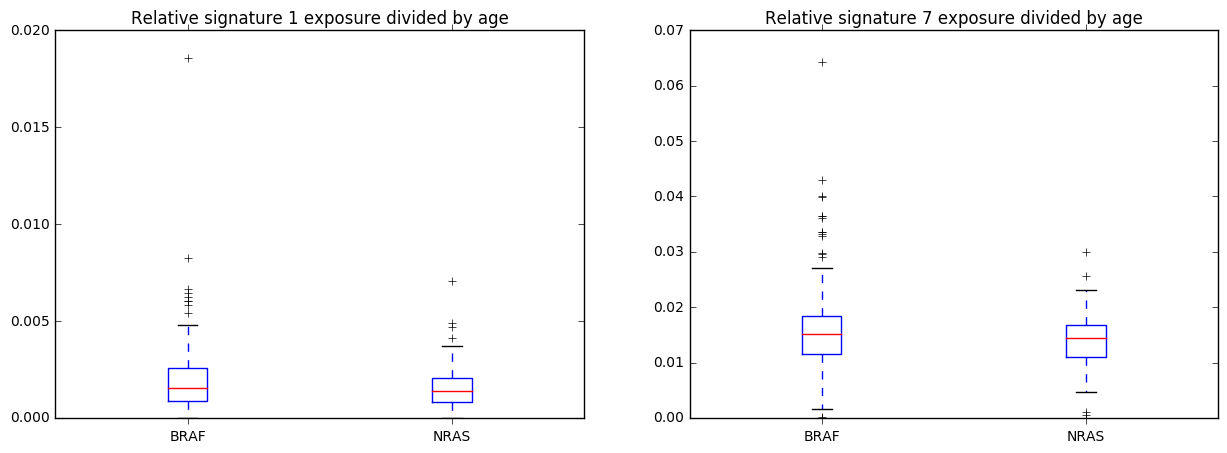

In [11]:
E_age = E_red/np.tile(ages.reshape((len(ages),1)), (1,E_red.shape[1]))
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,5)
labels = ['BRAF', 'NRAS']
ax[0].boxplot([E_age[braf_inds,0], E_age[nras_inds,0]])
ax[0].set_title('Relative signature 1 exposure divided by age')
ax[0].set_xticklabels(labels)
ax[1].boxplot([E_age[braf_inds,1], E_age[nras_inds,1]])
ax[1].set_title('Relative signature 7 exposure divided by age')
ax[1].set_xticklabels(labels)
plt.show()

Comparing the relative contributions does not seem conclusive here. Let's look at the correlation with age of these.

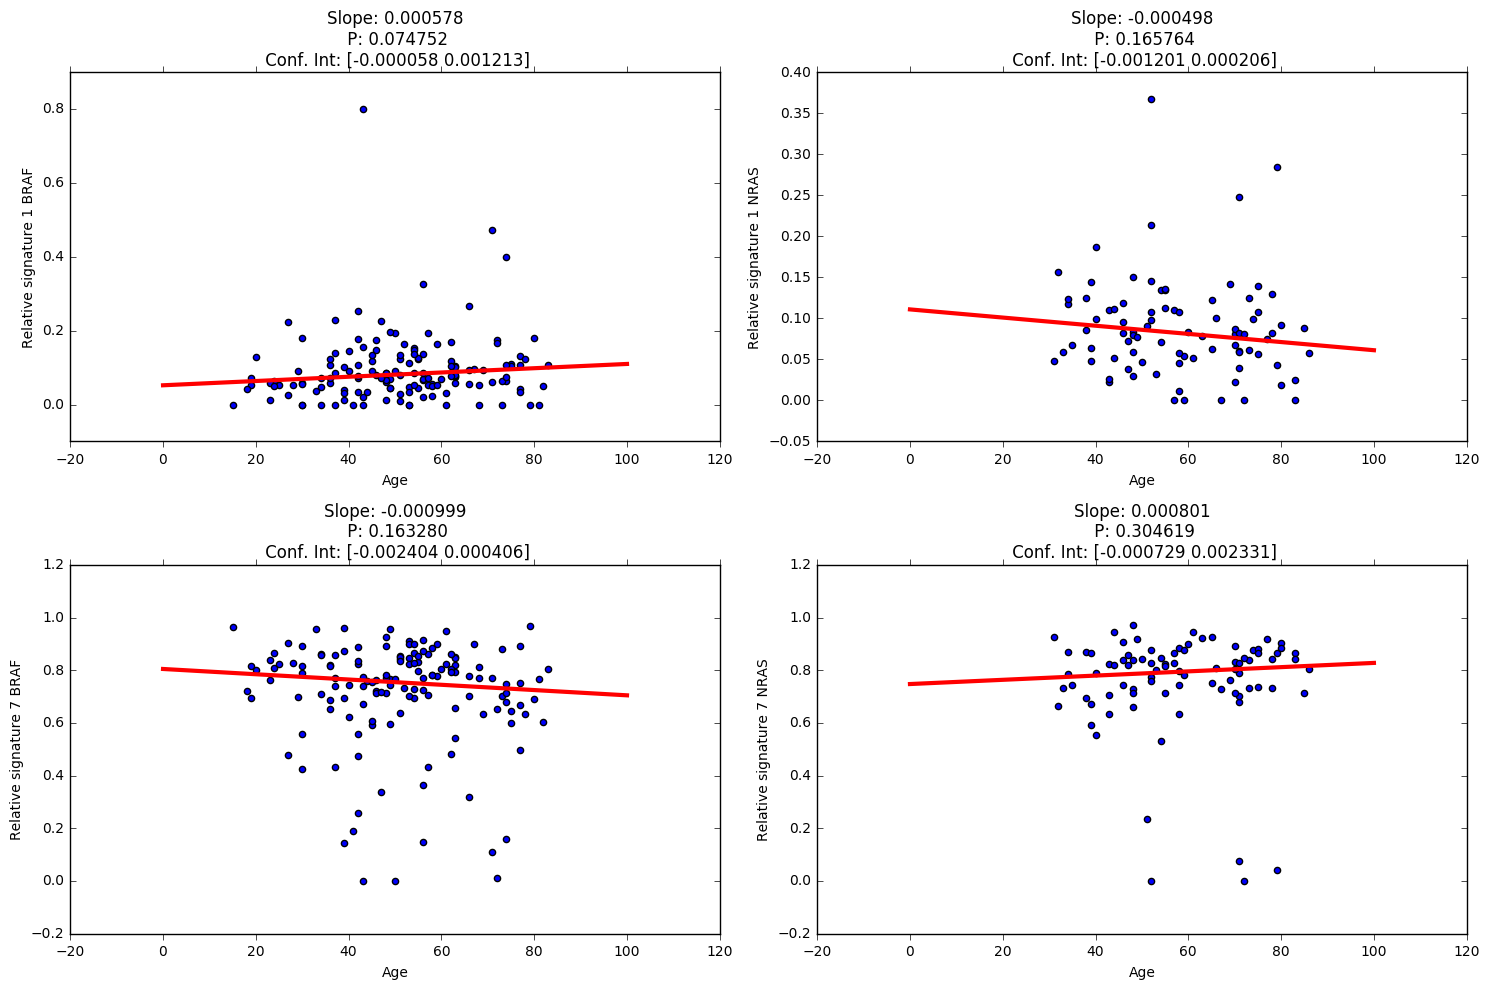

In [12]:
# Plot the new data
X = sm.add_constant(ages.reshape((len(ages),1)))
fig, ax = plt.subplots(2,2)
fig.set_size_inches(15,10)
ylabels = ["Relative signature 1", "Relative signature 7"]

for i in range(2):
    ax[i,0].scatter(ages[braf_inds], E_red[braf_inds,i])
    res = sm.RLM(E_red[braf_inds,i], X[braf_inds,:], M=sm.robust.norms.HuberT(1.345)).fit()
    ax[i,0].plot(xx, res.params[0]+res.params[1]*xx, linewidth=3, color='red')
    mytitle = "Slope: {:f}".format(res.params[1])+"\n P: {:f}".format(res.pvalues[1])+"\n Conf. Int: [{:f} {:f}]".format(*res.conf_int()[1,:])
    ax[i,0].set_title(mytitle)
    ax[i,0].set_ylabel(ylabels[i]+" BRAF")
    ax[i,0].set_xlabel("Age")
    
    ax[i,1].scatter(ages[nras_inds], E_red[nras_inds,i])
    res = sm.RLM(E_red[nras_inds,i], X[nras_inds,:], M=sm.robust.norms.HuberT(1.345)).fit()
    ax[i,1].plot(xx, res.params[0]+res.params[1]*xx, linewidth=3, color='red')
    mytitle = "Slope: {:f}".format(res.params[1])+"\n P: {:f}".format(res.pvalues[1])+"\n Conf. Int: [{:f} {:f}]".format(*res.conf_int()[1,:])
    ax[i,1].set_title(mytitle)
    ax[i,1].set_ylabel(ylabels[i]+" NRAS")
    ax[i,1].set_xlabel("Age")
plt.tight_layout()
plt.show()

This does not look very enlighening. Again, it appears that the difference between the two is not in the ratios, but in the absolute counts. For that purpose we project the mutation catalogs to the convex cone generaged by signatures 1, 5 and 7, and then look at the contributions of signatures 1 and 7 in that representation. The function **extract** just does a simple non-negatively constrained least squares procedure to project a mutation catalog on a combination of signatures (in our case 3).

In [13]:
from scipy.optimize import nnls

def extract(M, P, bootstrap=0):
    """Extract the exposures of P in M by non-negative least squares"""
    k, g = M.shape
    n = P.shape[1] 
    E = np.zeros((n, g))
    errors = np.zeros(g)
    
    if bootstrap>0:
        # Do bootstrapping    
        for b in range(bootstrap):
            B = np.zeros(M.shape)
            column_sum = np.sum(M, 0)
            norm_data = M / np.tile(column_sum, (k, 1))
            for i in range(g):
                B[:, i] = rnd.multinomial(np.ceil(column_sum[i]), norm_data[:, i])
                E_, e_ = nnls(P, M[:,i])
                E[:,i] += E_
                errors[i] += e_
        # Average out
        E = E/bootstrap
        errors = errors/bootstrap
    else:
        for i in range(M.shape[1]):
            E[:,i], errors[i] = nnls(P, M[:,i])
    return E, errors

Get mutation catalog used in MC1R paper. We project each sample $\vct{m}$ as

\begin{equation*}
  \vct{m} \approx e_1 \vct{p}_1+e_5\vct{p}_5+e_7\vct{p}_7.
\end{equation*}

As measure of the expression of signature 7 we could either use the coefficient e_7, or some norm of $e_7\vct{p}_7$. For example, if the above representation was exact, then summing the coordinates of $e_7\vct{p}_7$ would just give the number of SNVs associated with signature 7.

**Question: ** When we talk about "number of mutations associated to signature 1", do we count he **exposure** $e_1$, which counts how much signature 1 appears, or the total number of SNVs associated to signature 1, which would be the sum of the 96 components of $e_1\vct{p}_1$. In the [Clock paper](http://www.nature.com/ng/journal/v47/n12/full/ng.3441.html) they seem to use the coefficients.

In [14]:
M = mc1r3[[x for x in mc1r3.columns if '.in.' in x]].values.astype('float').transpose()
E_new, errors = extract(M, P)
M_proj = np.dot(P,E_new)
E_new = E_new.transpose()

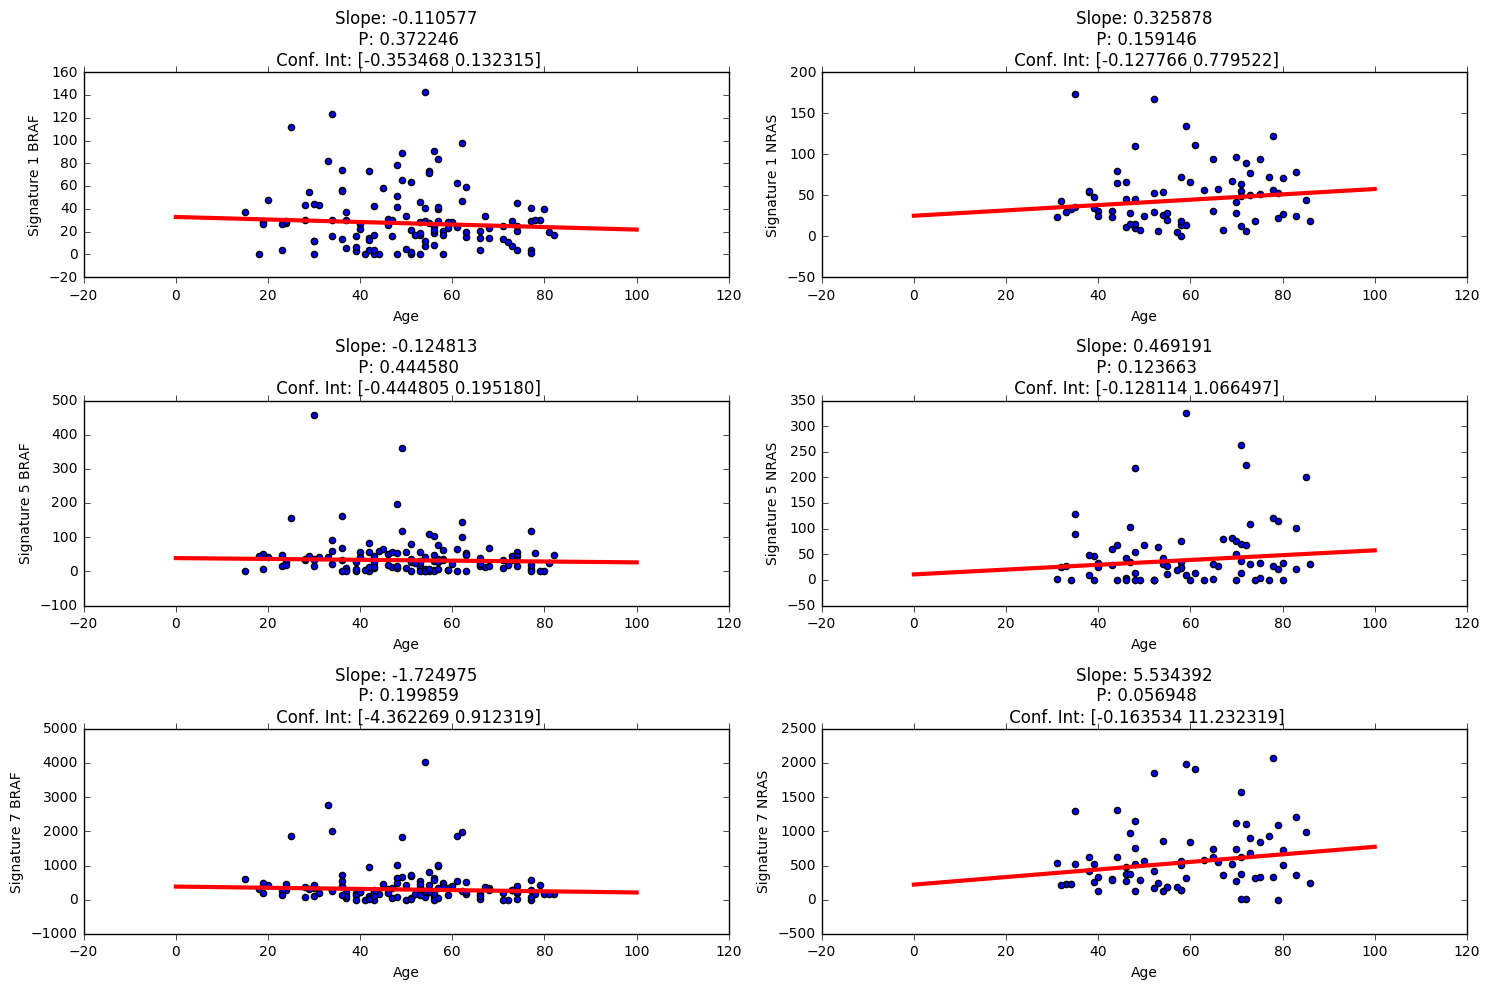

In [15]:
# Plot the new data
X = sm.add_constant(ages_1.reshape((len(ages_1),1)))
fig, ax = plt.subplots(3,2)
fig.set_size_inches(15,10)
ylabels = ["Signature 1", "Signature 5", "Signature 7"]

for i in range(3):
    ax[i,0].scatter(ages_1[braf_inds_1], E_new[braf_inds_1,i])
    rlm = sm.RLM(E_new[braf_inds_1,i], X[braf_inds_1,:], M=sm.robust.norms.HuberT(1.345))
    res = rlm.fit()
    ax[i,0].plot(xx, res.params[0]+res.params[1]*xx, linewidth=3, color='red')
    mytitle = "Slope: {:f}".format(res.params[1])+"\n P: {:f}".format(res.pvalues[1])+"\n Conf. Int: [{:f} {:f}]".format(*res.conf_int()[1,:])
    ax[i,0].set_title(mytitle)
    ax[i,0].set_ylabel(ylabels[i]+" BRAF")
    ax[i,0].set_xlabel("Age")
    
    ax[i,1].scatter(ages_1[nras_inds_1], E_new[nras_inds_1,i])
    rlm = sm.RLM(E_new[nras_inds_1,i], X[nras_inds_1,:], M=sm.robust.norms.HuberT(1.345))
    res = rlm.fit()
    ax[i,1].plot(xx, res.params[0]+res.params[1]*xx, linewidth=3, color='red')
    mytitle = "Slope: {:f}".format(res.params[1])+"\n P: {:f}".format(res.pvalues[1])+"\n Conf. Int: [{:f} {:f}]".format(*res.conf_int()[1,:])
    ax[i,1].set_title(mytitle)
    ax[i,1].set_ylabel(ylabels[i]+" NRAS")
    ax[i,1].set_xlabel("Age")
plt.tight_layout()
plt.show()

Again, think look pretty static with BRAF. Now let's look at the ratio with age.

In [16]:
types = ['Signature 1', 'Signature 7']
for i in range(2):
    res_nras = sm.RLM(E_new[nras_inds_1,i], np.ones_like(E_new[nras_inds_1,i]), M=sm.robust.norms.HuberT(1.345)).fit()
    print "The robust average of "+types[i]+" among NRAS is {:f}".format(res_nras.params[0])+" with confidence interval [{:f}, {:f}]".format(*res_nras.conf_int()[0,:])
    res_braf =  sm.RLM(E_new[braf_inds_1,i], np.ones_like(E_new[braf_inds_1,i]), M=sm.robust.norms.HuberT(1.345)).fit()
    print "The robust average of "+types[i]+" among BRAF is {:f}".format(res_braf.params[0])+" with confidence interval [{:f}, {:f}]".format(*res_braf.conf_int()[0,:])

The robust average of Signature 1 among NRAS is 43.969793 with confidence interval [37.009747, 50.929839]
The robust average of Signature 1 among BRAF is 27.367478 with confidence interval [23.519215, 31.215741]
The robust average of Signature 7 among NRAS is 38.585041 with confidence interval [29.363442, 47.806641]
The robust average of Signature 7 among BRAF is 32.723948 with confidence interval [27.607218, 37.840677]


Here we look at the joint contribution of signatures 1 and 5, and the contribution of signature 7. We do this as follows: in the representation

\begin{equation*}
  \vct{m}\approx e_1\vct{p}_1 + e_5\vct{p}_5 + e_7\vct{p}_7
\end{equation*}

we sum all the entries of $e_1\vct{p}_1+e_5\vct{p}_5$ and all those of $e_7\vct{p}_7$, and record them in two different numbers (total SNVs associated to Sig 1 and Sig 5, and associated to Sig 7).

In [17]:
M = np.zeros((P.shape[0],E_new.shape[0],E_new.shape[1]))
for i in range(3):
    M[:,:,i] = np.outer(P[:,i], E_new[:,i])
Sig1 = np.sum(M[:,:,0], axis=0)
Sig5 = np.sum(M[:,:,1], axis=0)
Sig1_Sig5 = np.sum(M[:,:,0]+M[:,:,1], axis=0)
Sig7 = np.sum(M[:,:,2], axis=0)
Sig_ratio = Sig7/Sig1_Sig5
sig_matrix = np.concatenate((Sig1_Sig5.reshape(-1,1), Sig7.reshape(-1,1), Sig_ratio.reshape(-1,1)), axis=1)

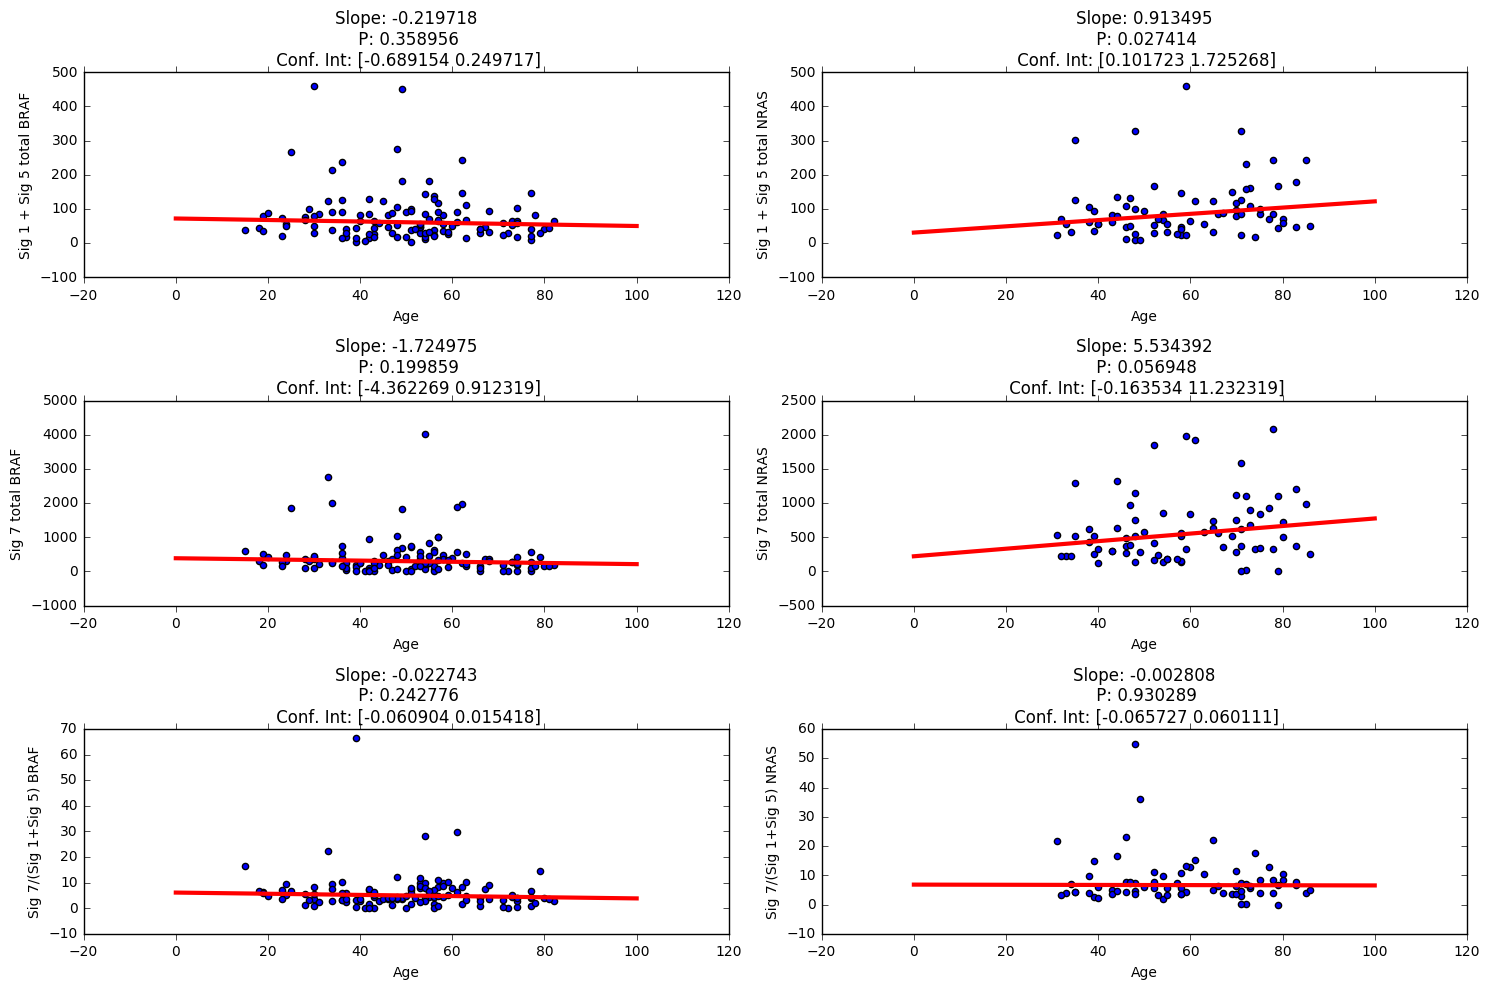

In [18]:
# Plot the new data
X = sm.add_constant(ages_1.reshape((len(ages_1),1)))
fig, ax = plt.subplots(3,2)
fig.set_size_inches(15,10)
ylabels = ["Sig 1 + Sig 5 total", "Sig 7 total", "Sig 7/(Sig 1+Sig 5)"]

for i in range(3):
    ax[i,0].scatter(ages_1[braf_inds_1], sig_matrix[braf_inds_1,i])
    res = sm.RLM(sig_matrix[braf_inds_1,i], X[braf_inds_1,:], M=sm.robust.norms.HuberT(1.345)).fit()
    ax[i,0].plot(xx, res.params[0]+res.params[1]*xx, linewidth=3, color='red')
    mytitle = "Slope: {:f}".format(res.params[1])+"\n P: {:f}".format(res.pvalues[1])+"\n Conf. Int: [{:f} {:f}]".format(*res.conf_int()[1,:])
    ax[i,0].set_title(mytitle)
    ax[i,0].set_ylabel(ylabels[i]+" BRAF")
    ax[i,0].set_xlabel("Age")
    
    ax[i,1].scatter(ages_1[nras_inds_1], sig_matrix[nras_inds_1,i])
    res = sm.RLM(sig_matrix[nras_inds_1,i], X[nras_inds_1,:], M=sm.robust.norms.HuberT(1.345)).fit()
    ax[i,1].plot(xx, res.params[0]+res.params[1]*xx, linewidth=3, color='red')
    mytitle = "Slope: {:f}".format(res.params[1])+"\n P: {:f}".format(res.pvalues[1])+"\n Conf. Int: [{:f} {:f}]".format(*res.conf_int()[1,:])
    ax[i,1].set_title(mytitle)
    ax[i,1].set_ylabel(ylabels[i]+" NRAS")
    ax[i,1].set_xlabel("Age")
plt.tight_layout()
plt.show()

Again, this confirms the previous analysis. Not quite sure how to interpret the fact that the NRAS samples correlate with age, irrespective of signature, while the BRAF samples appear to do less so.

---
## <font color="grey">  3. Can we tell NRAS from BRAF from the data alone?</font>
---

Given the two schematic graphs on the first page of Amaya's notes, I was curious about it whether one can get those graphs from the data. 

In [19]:
# Complete data sent by Simon, use only Sigs 1 and 7
tcga_sigs = pd.read_csv('data/tcga_sigs_229_sig.csv')
dataset = tcga_sigs.loc[:,['Signature.1', 'Signature.7']].values.astype('float')
labels = tcga_sigs.values[:,-1]

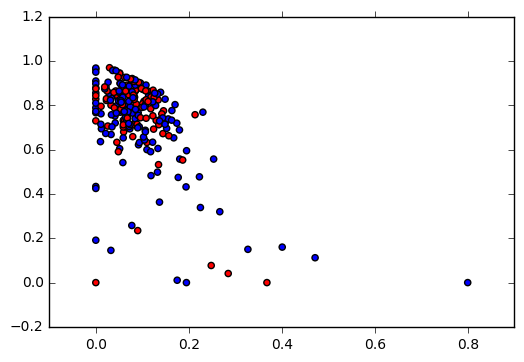

In [20]:
# Plot non-UV SNVS against UV SNVS
colordict = {'BRAF': 'blue', 'NRAS': 'red'}
colors = [colordict[x] for x in labels]
plt.scatter(dataset[:,0], dataset[:,1], c=colors)
plt.show()

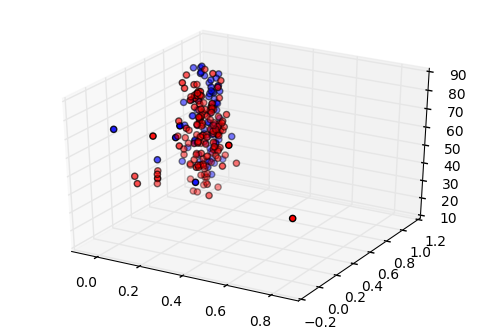

In [21]:
# 3D Plot including age information
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataset[braf_inds,0], dataset[braf_inds,1], ages[braf_inds], c='r')
ax.scatter(dataset[nras_inds,0], dataset[nras_inds,1], ages[nras_inds], c='b')
plt.show()

I've experimented a bit with supervised learning methods and logistic regression on this data, but nothing worthwile came out of that.